# Çok Değişkenli Tahmin için Ayrı SARIMA Modelleri

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings

# Metrikler ve testler için
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# SARIMA ve auto_arima için
import statsmodels.api as sm
import pmdarima as pm

# MAPE fonksiyonu
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

## Adım 1: Veri Yükleme ve Hazırlama

Kernel'ın ölmesini önlemek için veriyi 30 dakikalık ortalamalara yeniden örnekleyeceğiz, 3 sütunu da koruyacağız.

In [2]:
# İşlenmiş veriyi oku
df = pd.read_csv('genel_sunucu_yuku_tum_metrikler.csv', index_col='timestamp')
df.index = pd.to_datetime(df.index, unit='s')

# Veriyi 30 dakikalık aralıklara yeniden örnekle
df_resampled = df.resample('30min').mean().dropna()

# Tahmin edilecek sütunlar
target_columns = ['avg_min_cpu', 'avg_max_cpu', 'avg_avg_cpu']
ts_data = df_resampled[target_columns]

# Veriyi eğitim ve test setlerine ayır (Son 1 gün test verisi)
new_test_size = 48
train_data = ts_data[:-new_test_size]
test_data = ts_data[-new_test_size:]

print(f"Eğitim verisi boyutu: {len(train_data)}")
print(f"Test verisi boyutu: {len(test_data)}")

Eğitim verisi boyutu: 1392
Test verisi boyutu: 48


## Adım 2: Varsayımları Doğrulama

In [3]:
def adf_test(timeseries, series_name):
    print(f"--- '{series_name}' için Durağanlık Testi Sonuçları ---")
    result = adfuller(timeseries.dropna())
    print(f'ADF İstatistiği: {result[0]}')
    print(f'p-değeri: {result[1]}')
    if result[1] <= 0.05:
        print("Sonuç: Veri durağan görünüyor.")
    else:
        print("Sonuç: Veri durağan değil.")

# Her bir metrik için durağanlığı kontrol et
for column in target_columns:
    adf_test(train_data[column], column)
    print("-" * 50)

--- 'avg_min_cpu' için Durağanlık Testi Sonuçları ---
ADF İstatistiği: -5.056100984398591
p-değeri: 1.7166681824975573e-05
Sonuç: Veri durağan görünüyor.
--------------------------------------------------
--- 'avg_max_cpu' için Durağanlık Testi Sonuçları ---
ADF İstatistiği: -3.123780240740103
p-değeri: 0.024842668677788955
Sonuç: Veri durağan görünüyor.
--------------------------------------------------
--- 'avg_avg_cpu' için Durağanlık Testi Sonuçları ---
ADF İstatistiği: -4.379523018695559
p-değeri: 0.00032260542222395405
Sonuç: Veri durağan görünüyor.
--------------------------------------------------


'avg_avg_cpu' metriği için 400 gecikmeye kadar ACF grafiği:


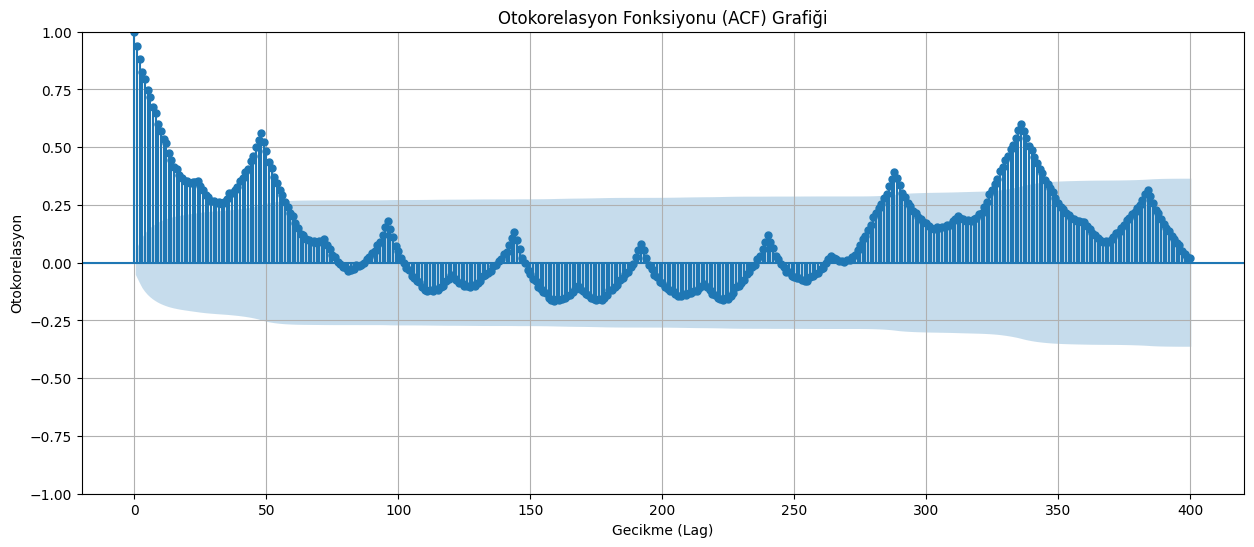

In [4]:
plt.rcParams['figure.figsize'] = (15, 6)
lags_to_check = 400 # Haftalık döngüyü görebilmek için

print(f"'avg_avg_cpu' metriği için {lags_to_check} gecikmeye kadar ACF grafiği:")
plot_acf(train_data['avg_avg_cpu'].dropna(), lags=lags_to_check)
plt.xlabel("Gecikme (Lag)")
plt.ylabel("Otokorelasyon")
plt.title("Otokorelasyon Fonksiyonu (ACF) Grafiği")
plt.grid(True)
plt.show()

plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

Grafikten de gözüktüğü üzere 48 ve 336 mevsimsellik söz konusu. Kernel died hatasını önlemek için s=48 ile devam edeceğim. 

(48 = Günlük Mevsimsellik)

(336 = Haftalık Mevsimsellik)

## Adım 3: Her Metrik İçin Otomatik Model Kurma ve Eğitme (`auto_arima`)

In [5]:
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

all_results = {}
start_time = time.time()

for column in target_columns:
    print(f"\n--- '{column}' için en iyi SARIMA modeli aranıyor... ---")
    
    auto_model = pm.auto_arima(
        train_data[column],
        start_p=1, start_q=1,
        test='adf',
        max_p=3, max_q=3,
        m=48,  # 30 dakikalık veri için günlük mevsimsellik
        d=None, D=None,
        seasonal=True,
        start_P=0, start_Q=0,
        trace=True, # Arama adımlarını gösterir
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True # Daha hızlı arama yapar
    )
    
    print(f"\n--- '{column}' için en iyi model bulundu: {auto_model.order} {auto_model.seasonal_order} ---")
    
    # Test verisi üzerinde tahmin yap
    predictions = auto_model.predict(n_periods=len(test_data))
    
    all_results[column] = {
        'predictions': predictions,
        'model_summary': auto_model.summary()
    }

end_time = time.time()
print(f"\nTüm modellerin eğitimi tamamlandı. Toplam süre: {end_time - start_time:.2f} saniye")



--- 'avg_min_cpu' için en iyi SARIMA modeli aranıyor... ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[48] intercept   : AIC=-3339.548, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=10.730, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=inf, Time=9.38 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=-1589.244, Time=3.32 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=9020.345, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[48] intercept   : AIC=-2753.127, Time=7.89 sec
 ARIMA(1,0,1)(0,0,1)[48] intercept   : AIC=-3476.492, Time=4.02 sec
 ARIMA(1,0,1)(1,0,1)[48] intercept   : AIC=inf, Time=9.93 sec
 ARIMA(1,0,1)(0,0,2)[48] intercept   : AIC=-3508.373, Time=56.36 sec
 ARIMA(1,0,1)(1,0,2)[48] intercept   : AIC=inf, Time=68.67 sec
 ARIMA(0,0,1)(0,0,2)[48] intercept   : AIC=-1589.485, Time=23.84 sec
 ARIMA(1,0,0)(0,0,2)[48] intercept   : AIC=-3494.158, Time=29.96 sec
 ARIMA(2,0,1)(0,0,2)[48] intercept   : AIC=-3567.891, Time=65.42 sec
 ARIMA(2,0,1)(0,0,1)[48] inte

## Adım 4: Sonuçları Görselleştirme

In [6]:
fig = go.Figure()

for column in target_columns:
    fig.add_trace(go.Scatter(
        x=test_data.index, y=test_data[column], mode='lines', name=f'Gerçek {column}'
    ))
    fig.add_trace(go.Scatter(
        x=all_results[column]['predictions'].index, y=all_results[column]['predictions'].values,
        mode='lines', name=f'Tahmin {column}', line=dict(dash='dash')
    ))

fig.update_layout(
    title='CPU Metrikleri: Gerçek Değerler vs. Optimize Edilmiş SARIMA Tahminleri',
    xaxis_title='Zaman', yaxis_title='Ortalama CPU Yükü (%)'
)
fig.show()


## Adım 5: Model Performansını Değerlendirme (Metrikler)

In [7]:
print("--- Tüm Modeller İçin Performans Metrikleri ---")
for column in target_columns:
    y_true = test_data[column].values
    y_pred = all_results[column]['predictions'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n--- Metrik: '{column}' ---")
    print(f"  Ortalama Mutlak Hata (MAE): {mae:.2f}")
    print(f"  Kök Ortalama Kare Hata (RMSE): {rmse:.2f}")
    print(f"  R-Kare (R²): {r2:.2f}")
    print(f"  Ortalama Mutlak Yüzde Hata (MAPE): {mape:.2f}%")


--- Tüm Modeller İçin Performans Metrikleri ---

--- Metrik: 'avg_min_cpu' ---
  Ortalama Mutlak Hata (MAE): 0.18
  Kök Ortalama Kare Hata (RMSE): 0.20
  R-Kare (R²): -1.40
  Ortalama Mutlak Yüzde Hata (MAPE): 3.01%

--- Metrik: 'avg_max_cpu' ---
  Ortalama Mutlak Hata (MAE): 0.56
  Kök Ortalama Kare Hata (RMSE): 0.63
  R-Kare (R²): -0.17
  Ortalama Mutlak Yüzde Hata (MAPE): 2.94%

--- Metrik: 'avg_avg_cpu' ---
  Ortalama Mutlak Hata (MAE): 0.38
  Kök Ortalama Kare Hata (RMSE): 0.42
  R-Kare (R²): -1.21
  Ortalama Mutlak Yüzde Hata (MAPE): 4.02%


## Adım 6: Hata (Artık) Analizi

In [8]:
print("--- Hata (Artık) Analizi ---")
for column in target_columns:
    residuals = test_data[column] - all_results[column]['predictions']
    print(f"\n--- '{column}' İçin Hata Analizi Grafikleri ---")
    
    # Hataların zaman içindeki dağılımı
    fig_res_time = px.line(x=residuals.index, y=residuals.values, title=f"'{column}' İçin Hataların Zaman İçindeki Dağılımı")
    fig_res_time.add_hline(y=0, line_dash="dash", line_color="red")
    fig_res_time.update_layout(xaxis_title='Zaman', yaxis_title='Hata (Gerçek - Tahmin)')
    fig_res_time.show()

    # Hataların histogramı
    fig_hist = px.histogram(residuals, title=f"'{column}' İçin Hataların Dağılımı (Histogram)")
    fig_hist.update_layout(xaxis_title='Hata Değeri', yaxis_title='Frekans')
    fig_hist.show()


--- Hata (Artık) Analizi ---

--- 'avg_min_cpu' İçin Hata Analizi Grafikleri ---



--- 'avg_max_cpu' İçin Hata Analizi Grafikleri ---



--- 'avg_avg_cpu' İçin Hata Analizi Grafikleri ---
